In [1]:
# %cd DDPM

/home/qkrwnstj/backup/Diffusion/DDPM


In [1]:
"""import"""
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import CIFAR10
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
"""Device setting"""
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda:0'

In [6]:
# file_names = ["x_t"]
# for file_name in file_names:
#     display(Image(f"./img/{file_name}.png"))

In [7]:
"""X_0 에서 X_t를 만들 때, 고려해야 될 것은 time step이다. 즉 t에 맞는 alpha_bar를 가지고 와야한다."""
def gather_and_expand(coeff, t, xshape):
    # T / batch_size / batch x channel x width x height (32, 3, 32, 32)

    # batch_size / (channel, width, height)
    batch_size, *dims = xshape
    # T 개의 coeff 중에서, index가 t인 것들을 추출
    coeff_t = torch.gather(coeff, dim=0, index=t)
    # coeff_t를 각 batch에 곱할 수 있도록 reshape, 각 pixel마다 같은 값을 coefficient로 곱해주기 때문에 뒤의 차원이 (1,1,1)
    return coeff_t.view(batch_size, 1, 1, 1)

In [8]:
# file_names = ["Algorithm1-training"]
# for file_name in file_names:
#     display(Image(f"./img/{file_name}.png"))

In [9]:
def train(model, x_0):
    # T중에서 random sampling 이때, batch size만큼 sampling한다.  
    # ex) 만약 batch size가 4라면, t의 값은 [183, 501, 99, 875] 같이 batch_size 만큼이 0 ~ 999 내에서 random하게 샘플링 되고,
    t = torch.randint(T, size=(x_0.shape[0],), device=x_0.device)
    # output이 x_0 pixel size 만큼 noise를 prediction 하는 거여서, size 맞춰주기
    # epsilon(noise) 또한 x_0의 크기만큼(batch_size만큼)
    eps = torch.randn_like(x_0)
    
    # 위에서 뽑은 t = [183, 501, 99, 875]같은 값들을 이용해 coefficiet값들(alpha, alpha_bar, sqare_alpha_bar 같은 값들)에서 index로 값들을 뽑아내 사용해야함.
    # 이 값들을 입력 크기에 맞게 reshape을 해주면서 모델의 input에 맞게 expand도 해줘야 합니다. 
    # 예를 들어서 sqare root alpha_bar *  x_0를 계산해야하는데, 둘의 shape가 다르니 연산이 안됩니다. 그래서 dimension만 맞춰주기 위해 expand를 합니다.
    # x_0를 (4(batch_size), 3, 32, 32)라고 하면 sqare root alpha_bar는 t가 4이므로 [4, 1, 1, 1]이 되어야 하고, 이를 위해서 len(x_0)크기만큼 view를 해줍니다.
    # 그렇게 나온 값에 x_0를 곱해주면 됩니다. 그리고 
    # \sqrt{1-\bar{\alpha_t}}\epsilon을 계산하기 위해 둘의 shpae도 맞춰줍니다. 
    x_t = gather_and_expand(sqrt_alpha_bar, t, x_0.shape) * x_0 \
    + gather_and_expand(sqrt_one_minus_alpha_bar, t, x_0.shape) * eps
    
    loss = F.mse_loss(model(x_t,t), eps)

    return loss

In [10]:
# file_names = ["Algorithm2-sampling"]
# for file_name in file_names:
#     display(Image(f"./img/{file_name}.png"))

In [11]:
def sampling(model, x_T):
    x_t = x_T

    # 999 -> 0 
    for time_step in reversed(range(T)):
        # time_step의 값으로 batch_size 만큼 만들기, mini-batch data를 denoising 
        t = torch.full((x_T.shape[0], ), time_step, dtype=torch.long, device=DEVICE)
        eps = model(x_t, t)

        mean = gather_and_expand(inverse_sqrt_alpha, t, eps.shape) \
        * (x_t - gather_and_expand(eps_coeff, t, eps.shape) * eps)

        z = torch.randn_like(x_t) if time_step else 0
        var = torch.sqrt(gather_and_expand(sigma, t, eps.shape)) * z

        x_t = mean + var

    x_0 = x_t

    return x_0

In [12]:
"""prepare dataset"""
dataset = CIFAR10(
    root="./data", train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=128, shuffle=True, num_workers=4
)

Files already downloaded and verified


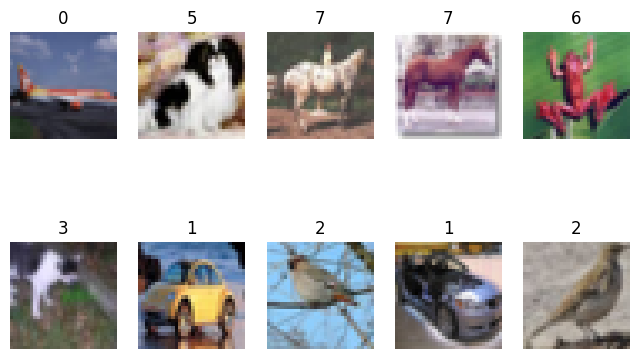

In [13]:
batch_x, batch_y = next(iter(dataloader))
plot_x, plot_y = batch_x[: 10,:,:], batch_y[:10]

figure = plt.figure(figsize=(8,5))
rows, cols = 2, 5

for i in range(1, rows*cols +1):
    img, label = plot_x[i-1], plot_y[i-1]
    img = img.permute(1,2,0)
    
    figure.add_subplot(rows, cols, i)
    plt.title(label.item())
    plt.axis('off')
    plt.imshow(img) # 0~1 or 0~255사이의 값을 넣어주면 자동으로 맞춰서 plot해줌

plt.show()

---

In [14]:
# file_names = ["swish"]
# for file_name in file_names:
#     display(Image(f"./img/{file_name}.png"))

In [15]:
"""create model"""
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

class TimeEmbedding(nn.Module):
    def __init__(self, T, d_model, dim):
        assert d_model % 2 == 0
        super().__init__()
        emb = torch.arange(0, d_model, step=2) / d_model * math.log(10000)
        emb = torch.exp(-emb)
        pos = torch.arange(T).float()
        emb = pos[:, None] * emb[None, :]
        emb = torch.stack([torch.sin(emb), torch.cos(emb)], dim=-1)
        emb = emb.view(T, d_model)

        self.timembedding = nn.Sequential(
            nn.Embedding.from_pretrained(emb),
            nn.Linear(d_model, dim),
            Swish(),
            nn.Linear(dim, dim),
        )
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)

    def forward(self, t):
        emb = self.timembedding(t)
        return emb

class DownSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        x = self.main(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        _, _, H, W = x.shape
        x = F.interpolate(
            x, scale_factor=2, mode='nearest')
        x = self.main(x)
        return x

class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.block2(h)

        h = h + self.shortcut(x)
        h = self.attn(h)
        return h

class UNet(nn.Module):
    def __init__(self, T, ch, ch_mult, attn, num_res_blocks, dropout):
        super().__init__()
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(T, ch, tdim)

        self.head = nn.Conv2d(3, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]  # record output channel when dowmsample for upsample
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            Swish(),
            nn.Conv2d(now_ch, 3, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, t):
        # Timestep embedding
        temb = self.time_embedding(t)
        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)
        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb)
        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)

        assert len(hs) == 0
        return h

In [16]:
import math 
from torch.nn import init

model = UNet(T=T, ch=128, ch_mult=[1, 2, 2, 1], attn=[1],
             num_res_blocks=2, dropout=0.1).to(DEVICE)

In [17]:
EPOCH = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
for epoch in range(EPOCH):
    model.train()
    for i, (x, _) in enumerate(dataloader):
        optimizer.zero_grad()
        x = x.to(DEVICE)
        loss = train(model, x)
        loss.backward()
        optimizer.step()
        print("\r[Epoch: {} , Iter: {}/{}]  Loss: {:.3f}".format(epoch, i, len(dataloader), loss.item()), end='')
    
    print("\n> Eval at epoch {}".format(epoch))
    model.eval()
    with torch.no_grad():
        x_T = torch.randn(5, 3, 32, 32).to(DEVICE)
        x_0 = sampling(model, x_T)
        #x_0가 0~1범위를 넘어설 수 있다.
        
        # x_0 = x_0*0.5 + 0.5
        x_0 = x_0.permute(0, 2, 3, 1).clamp(0, 1).detach().cpu().numpy() * 255
        for i in range(5):
            pil_image = Image.fromarray(x_0[i].astype(np.uint8))
            
            pil_image.save(f'./result/test{epoch}-{i}.png', 'png')

[Epoch: 0 , Iter: 390/391]  Loss: 0.025
> Eval at epoch 0
[Epoch: 1 , Iter: 390/391]  Loss: 0.017
> Eval at epoch 1
[Epoch: 2 , Iter: 390/391]  Loss: 0.022
> Eval at epoch 2
[Epoch: 3 , Iter: 390/391]  Loss: 0.018
> Eval at epoch 3
[Epoch: 4 , Iter: 390/391]  Loss: 0.018
> Eval at epoch 4
[Epoch: 5 , Iter: 390/391]  Loss: 0.025
> Eval at epoch 5
[Epoch: 6 , Iter: 390/391]  Loss: 0.016
> Eval at epoch 6
[Epoch: 7 , Iter: 390/391]  Loss: 0.018
> Eval at epoch 7
[Epoch: 8 , Iter: 390/391]  Loss: 0.017
> Eval at epoch 8
[Epoch: 9 , Iter: 390/391]  Loss: 0.018
> Eval at epoch 9
[Epoch: 10 , Iter: 390/391]  Loss: 0.013
> Eval at epoch 10
[Epoch: 11 , Iter: 390/391]  Loss: 0.021
> Eval at epoch 11
[Epoch: 12 , Iter: 390/391]  Loss: 0.017
> Eval at epoch 12
[Epoch: 13 , Iter: 390/391]  Loss: 0.011
> Eval at epoch 13
[Epoch: 14 , Iter: 390/391]  Loss: 0.015
> Eval at epoch 14
[Epoch: 15 , Iter: 390/391]  Loss: 0.012
> Eval at epoch 15
[Epoch: 16 , Iter: 390/391]  Loss: 0.018
> Eval at epoch 16


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt


rows, cols = 1, 5

epoch = 99

for e in range(epoch):
    figure = plt.figure(figsize=(6,2))
    num_images = 0
    for i in range(1, rows*cols+1):
        img = Image.open(f'./result/test{e}-{num_images}.png')
        figure.add_subplot(rows,cols,i)
        plt.axis('off')
        plt.imshow(img)
        num_images += 1
    plt.show()

## Custom Model

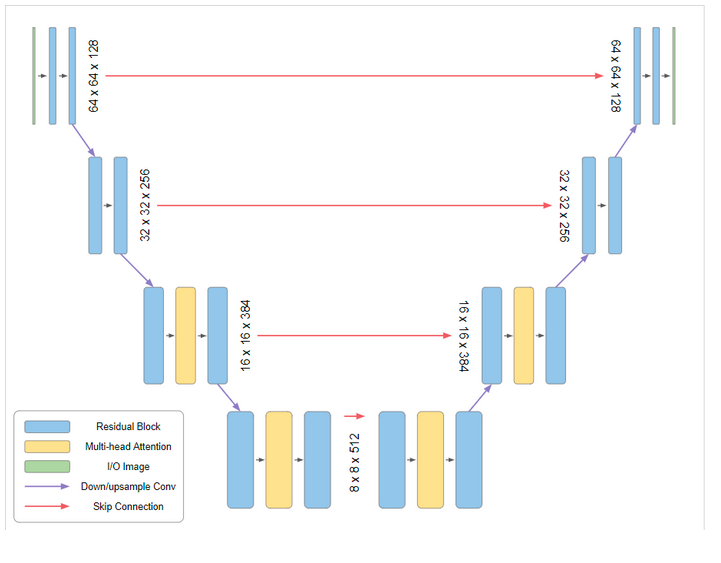

In [222]:
file_names = ["model-architecture"]
for file_name in file_names:
    display(Image(f"./img/{file_name}.png"))

- [32, 16, 8, 4] for 32x32 images </br> 
- 16x16 resolution에서 self-attention </br> -> 16, 8, 4 에서 진행
- sinusoidal position embedding in transformer </br> -> trainable 
- groupnormalization </br> -> batchnorm
- PixelCNN++ 과 비슷한 구조의 UNet 을 사용 </br> -> 위의 그림을 바탕으로 설계
- 각 resolution마다 2 개의 conv residual block </br> -> 그대로
- depth 단위로 skip connection </br> -> 그대로
- time step t는 각 residual block에 더해진다(채널에 따라 더해지는 t의 값이 다르게) </br> -> 그대로

- skip-connection -> add time embedding -> normalization -> activation function
- self-attention에 따라 성능 차이가 심하다.
- head는 하나다.

In [154]:
"""activation function"""
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
        
"""time embedding"""
class TimeEmbedding(nn.Module):
    def __init__(self, T=1000):
        super(TimeEmbedding, self).__init__()
        self.time_embedding = nn.Embedding(T, 512)

    def forward(self,t):
        time_embedding = self.time_embedding(t)
        return time_embedding
        
"""attention block"""
class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True):
        super(ResBlock, self).__init__()
        self.normalize = normalize
        self.normalize_ = nn.BatchNorm2d(out_channels)
        self.activation = Swish()
        #first conv
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(Swish())

        #second conv
        layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1))

        #make mini model
        self.model = nn.Sequential(*layers)

        if in_channels==out_channels:
            self.shortcut = nn.Identity()
        else:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

        self.time_layer = nn.Sequential(
            nn.Linear(512, out_channels),
            Swish()
        )
    def forward(self, x, time_embedding):
        x_ = self.model(x)
        x = x_ + self.shortcut(x)

        x += self.time_layer(time_embedding).view(x.size(0),x.size(1),1,1) #channel 단위로 더해주기
        if self.normalize:
            x = self.normalize_(x)
        x = self.activation(x)
        return x
        
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, attn=False):
        super(Block, self).__init__()

        layers = [ResBlock(in_channels, out_channels, normalize=True)]
        
        if attn:
            layers.append(AttnBlock(out_channels))
        layers.append(ResBlock(out_channels, out_channels, normalize=True))

        self.model = nn.ModuleList(layers)
        
    def forward(self, x, time_embedding):
        for layer in self.model:
            if isinstance(layer, AttnBlock):
                x = layer(x)
            else:
                x = layer(x, time_embedding)
       
        return x
        
class Down_Up_sampling(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, function="Down"):
        super(Down_Up_sampling, self).__init__()
        self.normalize = normalize
        self.normalize_ = nn.BatchNorm2d(out_channels)
        self.activation = Swish()
        
        #first conv
        if function=="Up":
            layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)]
        elif function=="Down":
            layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(Swish())

        #make mini model
        self.model = nn.Sequential(*layers)

    def forward(self, x, time_embedding):
        x = self.model(x)
        
        if self.normalize:
            x = self.normalize_(x)
        x = self.activation(x)
        
        return x
        
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.head = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.time_embedding = TimeEmbedding()
        self.model = nn.ModuleList([
            Block(32, 32), #32x32x32 -> 32x32x32
            Down_Up_sampling(32,64), #32x32x32 -> 64x16x16
            Block(64, 64, attn=True), #64x16x16 -> 64x16x16
            Down_Up_sampling(64,128), #64x16x16 -> 128x8x8
            Block(128, 128, attn=True), #128x8x8 -> 128x8x8
            Down_Up_sampling(128,256), #128x8x8 -> 256x4x4
            Block(256, 256, attn=True), # 256x4x4 -> 256x4x4
            Block(256*2, 256, attn=True), # 256*2x4x4 -> 256x4x4
            Down_Up_sampling(256,128,function="Up"), #256x4x4 -> 128x8x8
            Block(128*2, 128, attn=True), #128*2x8x8 -> 128x8x8
            Down_Up_sampling(128,64,function="Up"), #128x8x8 -> 64x16x16
            Block(64*2, 64, attn=True), #64*2x16x16 -> 64x16x16
            Down_Up_sampling(64,32,function="Up"), #64x16x16 -> 32x32x32
            Block(32*2, 32, attn=True), #32*2x32x32 -> 32x32x32
        ])

        self.tail = nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x, t):
        time_embedding = self.time_embedding(t)
        x = self.head(x)
        for_skip_connection = []
        #batch_size x channel x width x height / batch_size x time_embedding(512)
        for i, layer in enumerate(self.model,1):
            if i == 14:
                x = torch.cat([for_skip_connection[0], x],dim=1)
            if i == 12:
                x = torch.cat([for_skip_connection[1], x],dim=1)
            if i == 10:
                x = torch.cat([for_skip_connection[2], x],dim=1)
            if i == 8:
                x = torch.cat([for_skip_connection[3], x],dim=1)
            x = layer(x,time_embedding)
            if i==1 or i==3 or i==5 or i==7:
                for_skip_connection.append(x)
            

        #noise는 표준 정규 분포를 가지지만, 결국 범위자체는 한정되어 있지 않기 때문에 activation function을 씌우지 않는다.
        x = self.tail(x)
        
        return x 

In [156]:
model = Model().to(DEVICE)
model

Model(
  (head): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_embedding): TimeEmbedding(
    (time_embedding): Embedding(1000, 512)
  )
  (model): ModuleList(
    (0): Block(
      (model): ModuleList(
        (0-1): 2 x ResBlock(
          (normalize_): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): Swish()
          (model): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Swish()
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (shortcut): Identity()
          (time_layer): Sequential(
            (0): Linear(in_features=512, out_features=32, bias=True)
            (1): Swish()
          )
        )
      )
    )
    (1): Down_Up_sampling(
      (normalize_): BatchNorm2d(64, eps=1e-05, m

In [157]:
EPOCH = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

In [158]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
for epoch in range(EPOCH):
    model.train()
    for i, (x, _) in enumerate(dataloader):
        optimizer.zero_grad()
        x = x.to(DEVICE)
        loss = train(model, x)
        loss.backward()
        optimizer.step()
        print("\r[Epoch: {} , Iter: {}/{}]  Loss: {:.3f}".format(epoch, i, len(dataloader), loss.item()), end='')
    
    print("\n> Eval at epoch {}".format(epoch))
    model.eval()
    with torch.no_grad():
        #batchnorm을 썼으니 32개 sampling
        x_T = torch.randn(32, 3, 32, 32).to(DEVICE)
        x_0 = sampling(model, x_T)
        #x_0가 0~1범위를 넘어설 수 있다.
        
        # x_0 = x_0*0.5 + 0.5 <transforms.normalize를 하면 [-1,1]이므로>
        x_0 = x_0.permute(0, 2, 3, 1).clamp(0, 1).detach().cpu().numpy() * 255
        for i in range(5):
            pil_image = Image.fromarray(x_0[i].astype(np.uint8))
            
            pil_image.save(f'./custom_result/test{epoch}-{i}.png', 'png')

[Epoch: 0 , Iter: 1562/1563]  Loss: 0.037
> Eval at epoch 0
[Epoch: 1 , Iter: 1562/1563]  Loss: 0.029
> Eval at epoch 1
[Epoch: 2 , Iter: 1562/1563]  Loss: 0.060
> Eval at epoch 2
[Epoch: 3 , Iter: 1562/1563]  Loss: 0.035
> Eval at epoch 3
[Epoch: 4 , Iter: 1562/1563]  Loss: 0.033
> Eval at epoch 4
[Epoch: 5 , Iter: 1562/1563]  Loss: 0.011
> Eval at epoch 5
[Epoch: 6 , Iter: 1562/1563]  Loss: 0.013
> Eval at epoch 6
[Epoch: 7 , Iter: 1562/1563]  Loss: 0.012
> Eval at epoch 7
[Epoch: 8 , Iter: 1562/1563]  Loss: 0.012
> Eval at epoch 8
[Epoch: 9 , Iter: 1562/1563]  Loss: 0.009
> Eval at epoch 9
[Epoch: 10 , Iter: 1562/1563]  Loss: 0.038
> Eval at epoch 10
[Epoch: 11 , Iter: 1562/1563]  Loss: 0.023
> Eval at epoch 11
[Epoch: 12 , Iter: 1562/1563]  Loss: 0.006
> Eval at epoch 12
[Epoch: 13 , Iter: 1562/1563]  Loss: 0.019
> Eval at epoch 13
[Epoch: 14 , Iter: 1562/1563]  Loss: 0.005
> Eval at epoch 14
[Epoch: 15 , Iter: 1562/1563]  Loss: 0.014
> Eval at epoch 15
[Epoch: 16 , Iter: 1562/1563

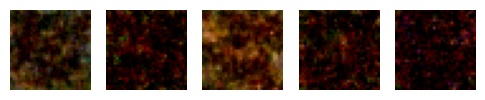

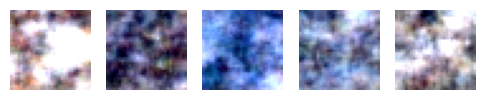

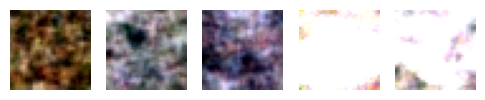

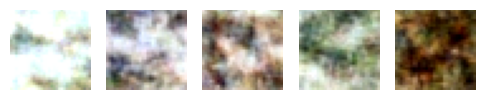

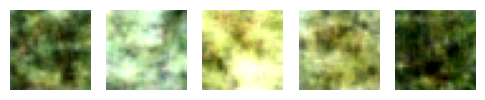

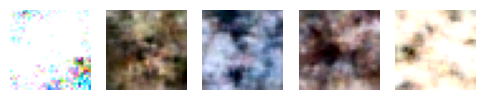

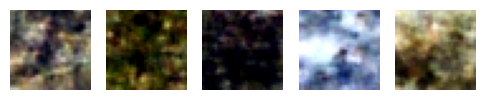

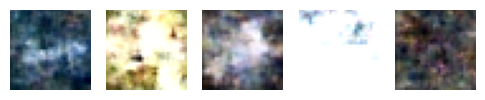

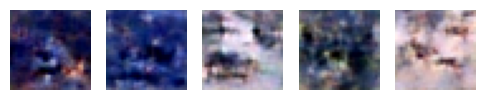

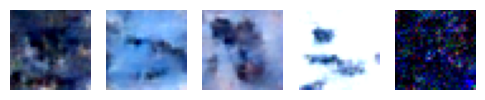

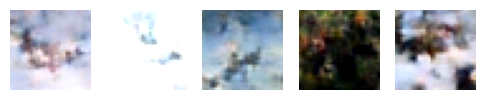

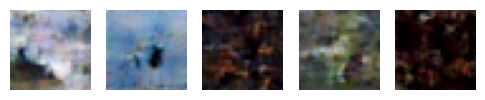

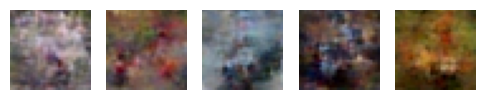

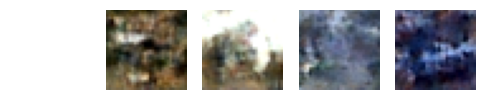

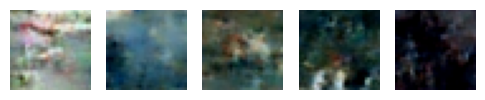

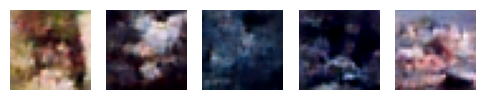

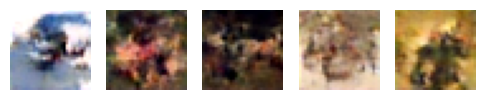

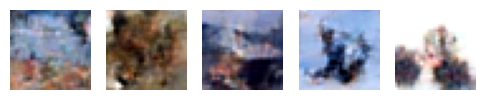

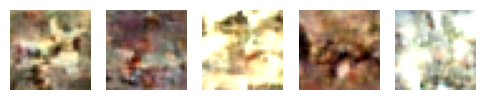

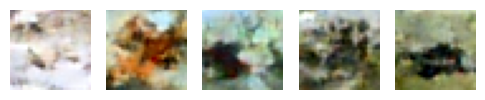

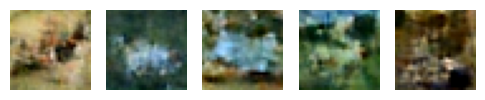

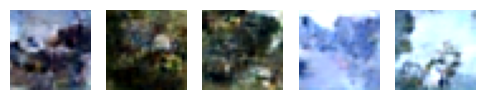

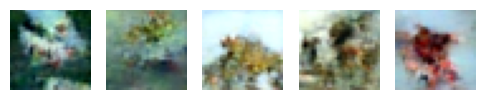

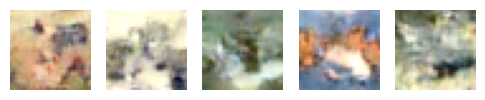

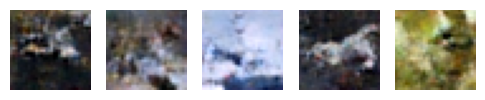

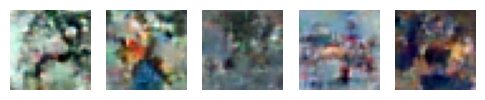

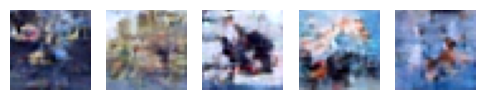

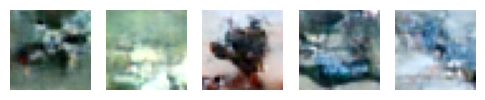

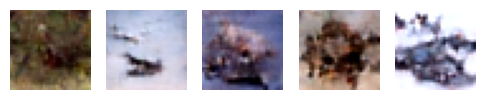

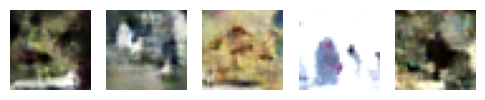

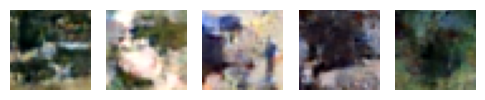

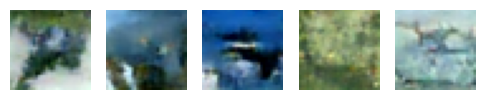

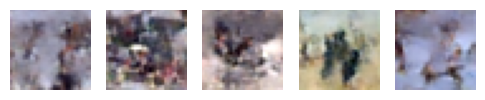

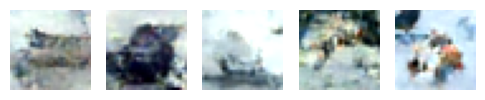

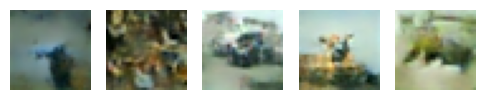

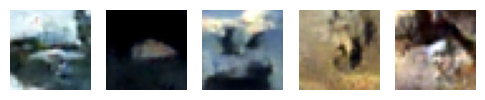

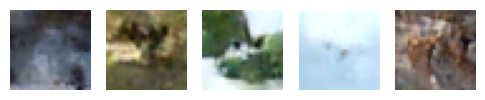

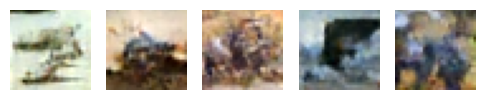

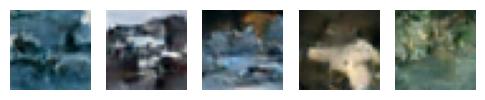

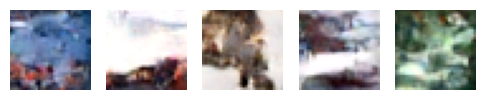

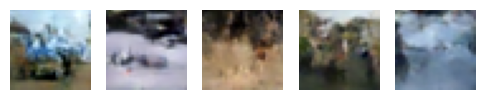

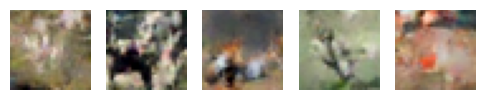

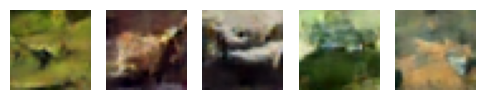

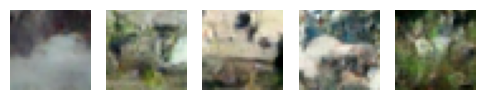

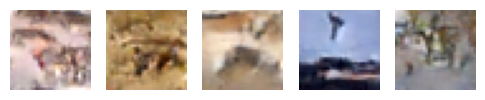

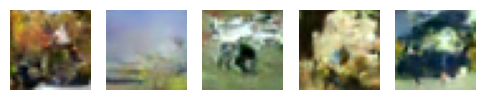

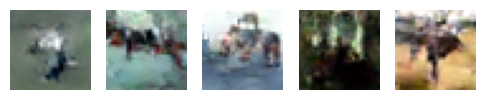

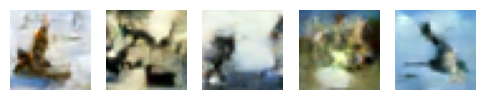

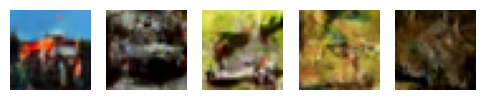

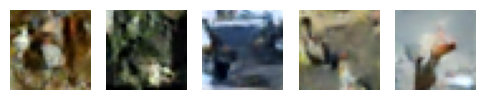

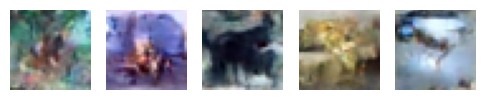

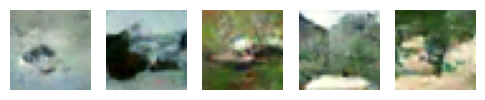

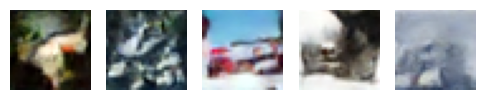

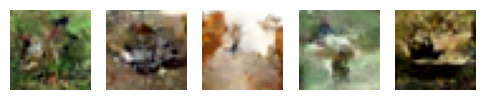

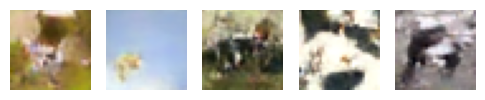

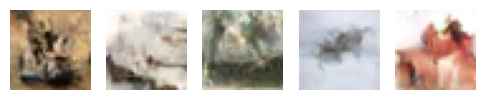

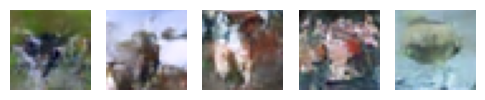

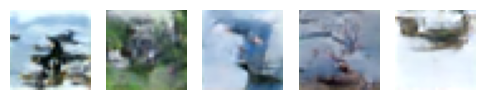

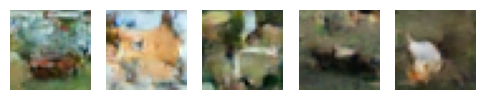

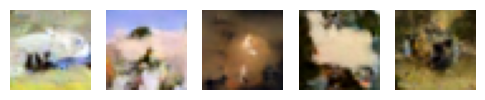

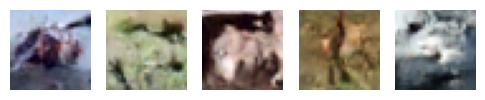

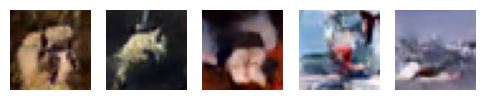

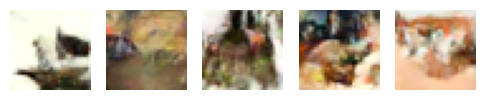

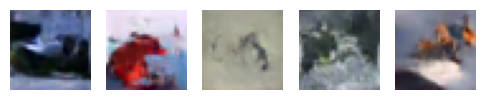

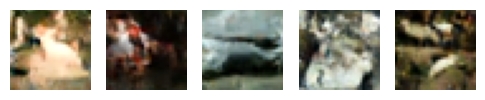

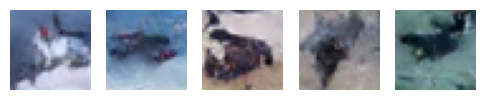

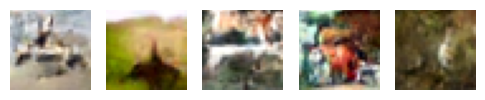

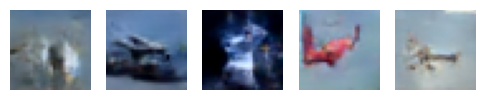

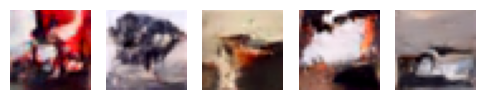

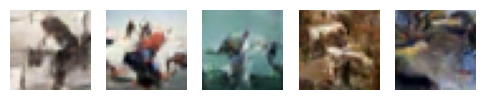

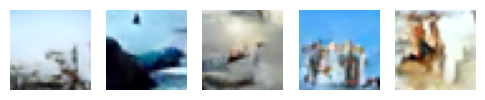

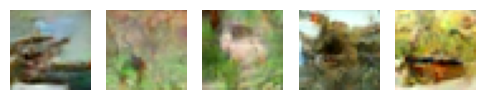

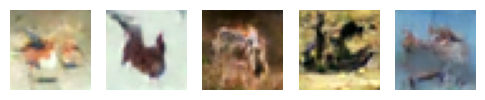

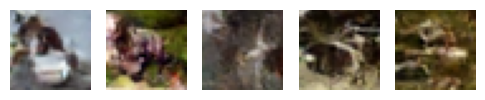

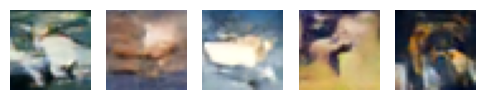

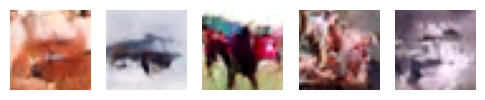

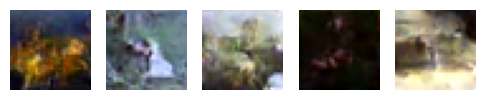

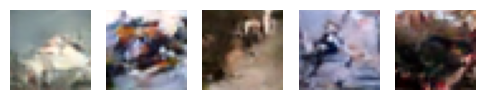

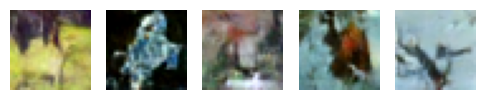

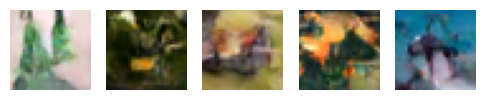

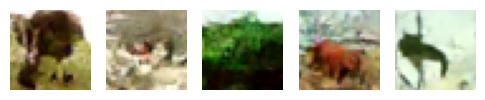

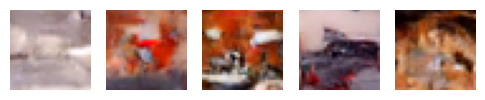

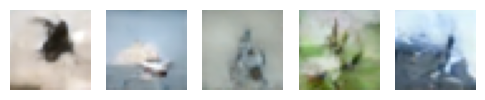

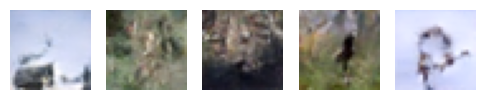

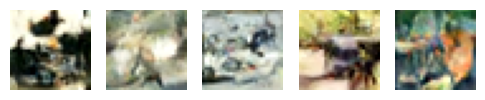

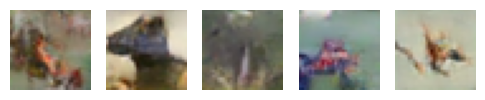

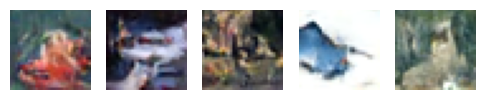

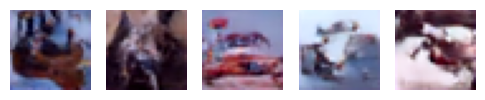

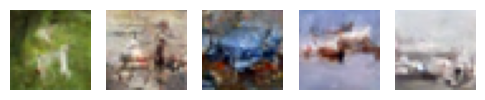

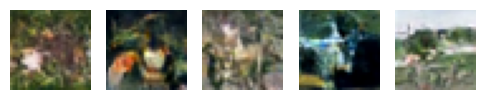

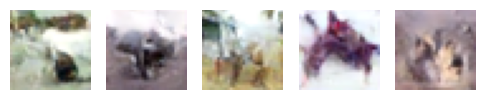

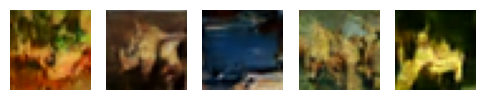

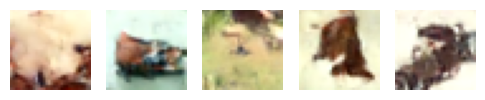

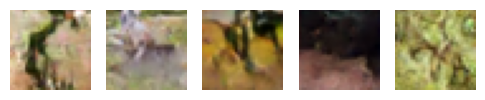

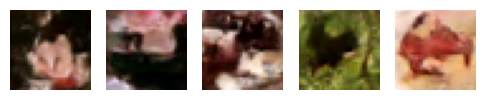

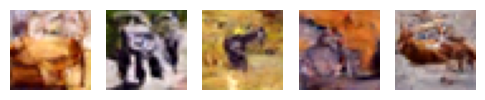

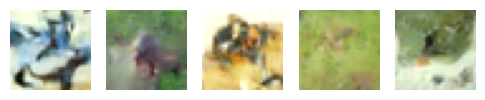

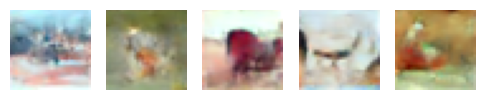

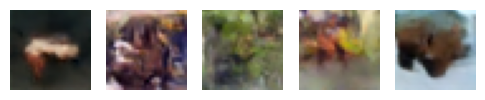

In [159]:
from PIL import Image
import matplotlib.pyplot as plt

rows, cols = 1, 5

epoch = 99

for e in range(epoch):
    figure = plt.figure(figsize=(6,2))
    num_images = 0
    for i in range(1, rows*cols+1):
        img = Image.open(f'./custom_result/test{e}-{num_images}.png')
        figure.add_subplot(rows,cols,i)
        plt.axis('off')
        plt.imshow(img)
        num_images += 1
    plt.show()

### result without Self-attention in 16x16 resolution

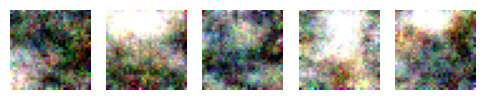

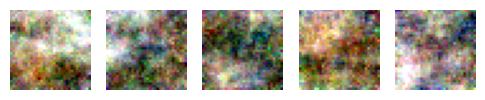

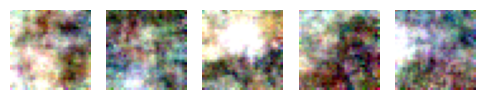

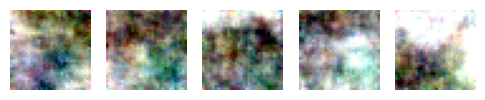

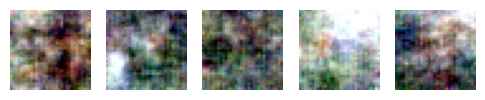

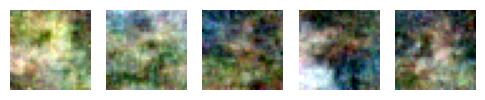

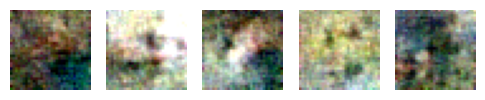

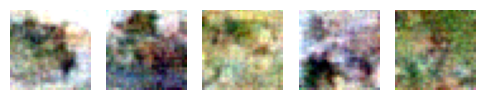

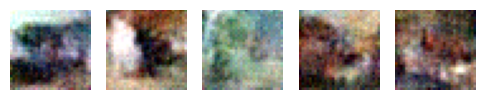

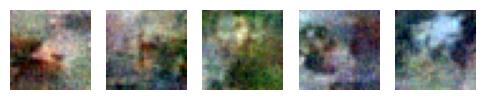

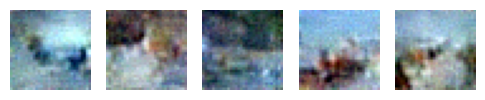

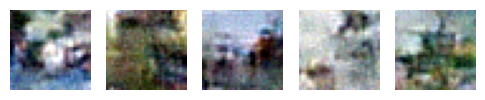

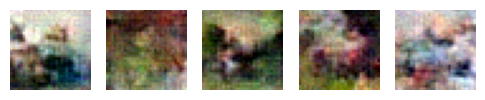

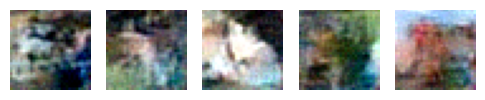

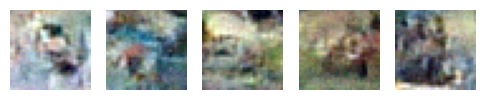

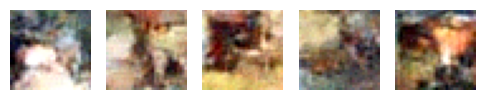

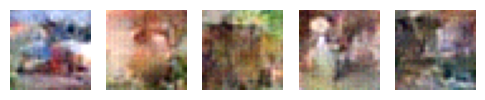

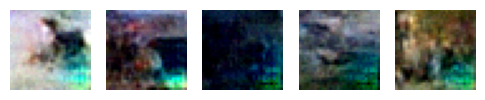

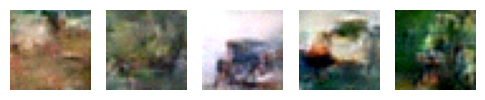

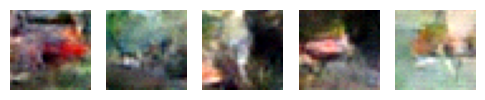

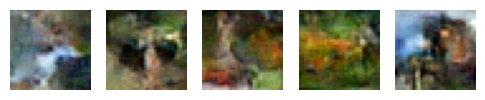

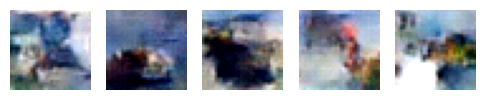

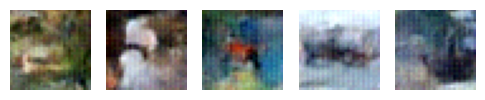

FileNotFoundError: [Errno 2] No such file or directory: './custom_result_without_self_attention/test23-0.png'

<Figure size 600x200 with 0 Axes>

In [42]:
from PIL import Image
import matplotlib.pyplot as plt

rows, cols = 1, 5

epoch = 99

for e in range(epoch):
    figure = plt.figure(figsize=(6,2))
    num_images = 0
    for i in range(1, rows*cols+1):
        img = Image.open(f'./custom_result_without_self_attention/test{e}-{num_images}.png')
        figure.add_subplot(rows,cols,i)
        plt.axis('off')
        plt.imshow(img)
        num_images += 1
    plt.show()